# Experimental/mixed approach
In this notebook, we will be testing a network which will use the data from dataset to train itself.

In [1]:
import torch
from torchvision.models import resnet18, resnet50
import model_utils
import plotter
import data_utils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset, Subset
import importlib
import torchvision.transforms as transforms

model_utils.fix_random(42)

## Preparing the data

As we're using a mixed approach, we would need to upscale the CIFAKE images to match the size of the other, more complicated ones. Obviously, we will apply all the other transformations needed to the RVAA dataset.

As the CIFAKE dataset is much more oversampled than the RVAA dataset (120'000 vs 1'000 samples) we need to take in consideration a very small subset of CIFAKE in order to create a properly balanced mixed dataset. In particular, we take about 1200 samples from CIFAKE.

In [2]:
IMG_SIZE = 224

transform_cifake = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')),  # Convert to RGB
    transforms.Resize((IMG_SIZE, IMG_SIZE)),                # Resize to IMG_SIZE
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


d1 = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="train", transform=transform_cifake)
d2 = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="test", transform=transform_cifake)
cifake_dataset = ConcatDataset([d1, d2])


# Selecting a subset of the CIFAKE datasets
portion_size = int(0.01 * len(cifake_dataset))  # Select 20% of the dataset
indices = list(range(portion_size))
cifake_dataset = Subset(cifake_dataset, indices)

transform_rvaa = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')), # Convert to RGB
    transforms.Resize(IMG_SIZE),                 # Resize to IMG_SIZE while keeping aspect ratio
    transforms.Lambda(data_utils.pad_to_square), # Apply the dynamic padding to make the image square
    transforms.Resize((IMG_SIZE, IMG_SIZE)),     # Ensure the final image is IMG_SIZExIMG_SIZE
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizing "should" help with Pretrained nets
])

rvaa_dataset = data_utils.RVAADataset(root_dir="data/RealVsAiArt", transform=transform_rvaa)

# the final dataset that's going to be used
merged_dataset = ConcatDataset([cifake_dataset, rvaa_dataset])

In [3]:
LEARNING_RATE = 3e-4
EPOCHS = 20
BATCH_SIZE = 64

In [4]:
train_dataset, val_dataset, test_dataset = data_utils.train_test_split((0.7, 0.15), dataset=merged_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, pin_memory=True)

## Model
Since the model that has been giving us great results so far is a ResNet50, we can try and use it again to see if it manages to capture the patterns learned from CIFAKE with the patterns learned from RealVsAiArt.

In [5]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=1)
device = model_utils.get_device()
print(f"using {device} device")
ft_resnet50.to(device)


loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)

dataloaders = (train_dataloader, val_dataloader)

using cuda device


## Training setup
The training is done using 10 epochs and a batch size of 64.
As before, we use a 2-step training method which allows us to train the classification head first and then the feature extractor. As shown in the CIFAKE model, this usually deals pretty good results.

In [6]:
model_name = "MixResNet"
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=True)

Epoch 1/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 80.3%, Avg loss: 0.430548
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 80.9%, Avg loss: 0.333476
New best model found! (based on lowest loss)
...and saved.


Epoch 3/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 81.8%, Avg loss: 0.314819
New best model found! (based on lowest loss)
...and saved.


Epoch 4/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 83.4%, Avg loss: 0.288855
New best model found! (based on lowest loss)
...and saved.


Epoch 5/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 84.3%, Avg loss: 0.273259
New best model found! (based on lowest loss)
...and saved.


Epoch 6/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 83.7%, Avg loss: 0.268178
New best model found! (based on lowest loss)
...and saved.


Epoch 7/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 83.7%, Avg loss: 0.262328
New best model found! (based on lowest loss)
...and saved.


Epoch 8/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 83.7%, Avg loss: 0.257351
New best model found! (based on lowest loss)
...and saved.


Epoch 9/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 83.1%, Avg loss: 0.263960


Epoch 10/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 86.5%, Avg loss: 0.240775
New best model found! (based on lowest loss)
...and saved.


Epoch 11/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 84.9%, Avg loss: 0.241745


Epoch 12/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 86.8%, Avg loss: 0.235690
New best model found! (based on lowest loss)
...and saved.


Epoch 13/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 85.8%, Avg loss: 0.232894
New best model found! (based on lowest loss)
...and saved.


Epoch 14/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 88.3%, Avg loss: 0.227518
New best model found! (based on lowest loss)
...and saved.


Epoch 15/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 87.4%, Avg loss: 0.227511
New best model found! (based on lowest loss)
...and saved.


Epoch 16/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 87.4%, Avg loss: 0.223946
New best model found! (based on lowest loss)
...and saved.


Epoch 17/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 88.3%, Avg loss: 0.220081
New best model found! (based on lowest loss)
...and saved.


Epoch 18/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 87.4%, Avg loss: 0.220648


Epoch 19/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 87.1%, Avg loss: 0.220615


Epoch 20/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 88.0%, Avg loss: 0.215723
New best model found! (based on lowest loss)
...and saved.




c:\Users\tekke\Desktop\ethics_project2\model_utils.py:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


In [7]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device)

Test Error:
Accuracy: 85.9%, Avg loss: 0.275477
Confusion matrix report, tp: 213, fp: 13, fn: 33, tn:67
Precision: 0.94, Recall: 0.87, F1-Score: 0.90


(0.2754773050546646, tensor(0.8589, device='cuda:0'))

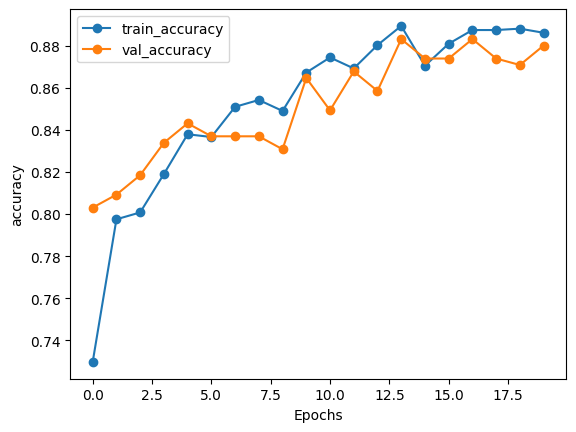

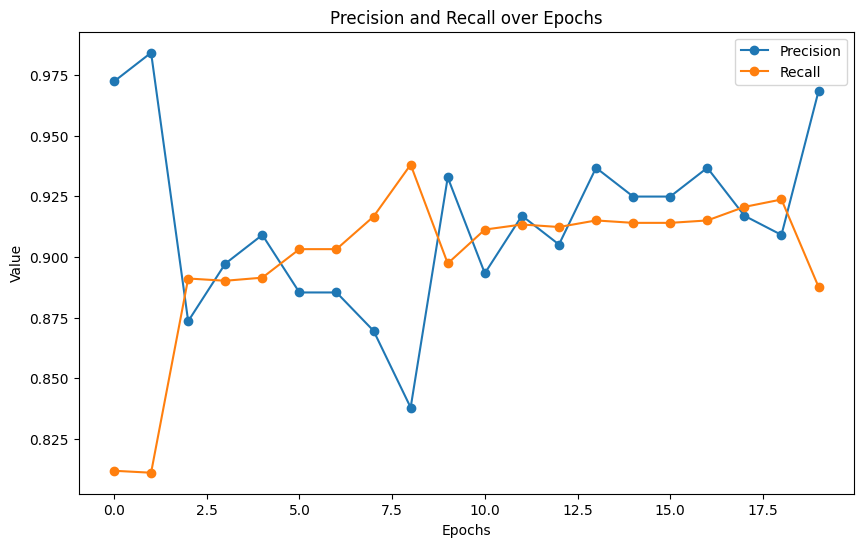

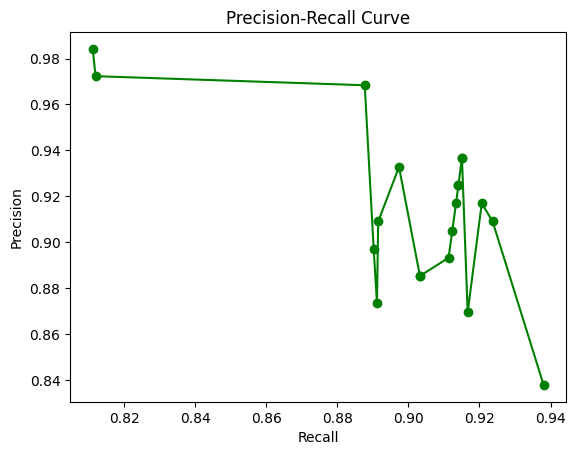

In [8]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

### Fine-tuning step 2
Using a 2-step fine-tuning, we are able to achieve much better performance.

In [9]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resnet50.parameters(), lr=LEARNING_RATE)

In [10]:
model_name = "MixResNet_beefy"
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=True)

Epoch 1/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 81.8%, Avg loss: 0.469282
New best model found! (based on lowest loss)
...and saved.


Epoch 2/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 84.3%, Avg loss: 0.473028


Epoch 3/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 81.8%, Avg loss: 0.570132


Epoch 4/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 82.5%, Avg loss: 0.588229


Epoch 5/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 86.5%, Avg loss: 0.536476


Epoch 6/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 87.7%, Avg loss: 0.326399
New best model found! (based on lowest loss)
...and saved.


Epoch 7/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 91.4%, Avg loss: 0.271940
New best model found! (based on lowest loss)
...and saved.


Epoch 8/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 90.5%, Avg loss: 0.242923
New best model found! (based on lowest loss)
...and saved.


Epoch 9/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 91.4%, Avg loss: 0.281936


Epoch 10/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 91.7%, Avg loss: 0.359180


Epoch 11/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 89.2%, Avg loss: 0.364028


Epoch 12/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 84.9%, Avg loss: 0.588807


Epoch 13/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 89.5%, Avg loss: 0.783792


Epoch 14/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 87.7%, Avg loss: 0.449673


Epoch 15/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 87.1%, Avg loss: 0.383818


Epoch 16/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 90.5%, Avg loss: 0.352179


Epoch 17/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 90.2%, Avg loss: 0.336834


Epoch 18/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 91.1%, Avg loss: 0.352046


Epoch 19/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 91.1%, Avg loss: 0.360089


Epoch 20/20
-------------------------------


c:\Users\tekke\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Error:
Accuracy: 91.4%, Avg loss: 0.362945




c:\Users\tekke\Desktop\ethics_project2\model_utils.py:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/best_MixResNet_beefy.pth'

In [21]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device)

Test Error:
Accuracy: 88.7%, Avg loss: 0.218408


(0.21840820709864298, tensor(0.8865, device='cuda:0'))

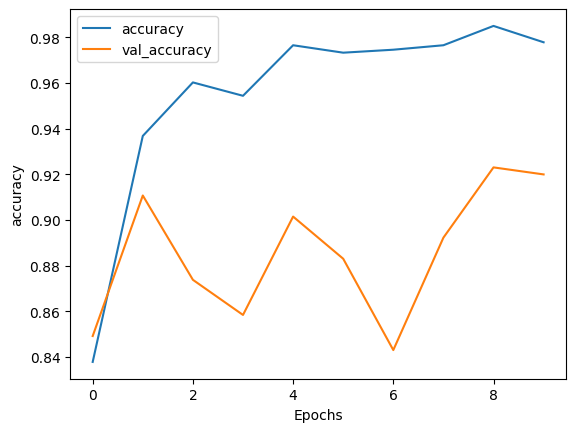

In [22]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts 
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)